# jammer
## 02 Explore the Marley models
### I- How to read them in

Michael Gully-Santiago  
Friday, March 31, 2017  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [3]:
import pandas as pd

In [4]:
from os import listdir

In [5]:
import astropy.units as u

In [6]:
! cat ../../Starfish/libraries/raw/marley/parameters

wavelength:  0.400000 to 50.000000um     skip=  1     resolution=      0.


In [7]:
! ls ../../Starfish/libraries/raw/marley/ | head -n 16

parameters
sp_t1000g1000nc_m0.0
sp_t1000g100nc_m0.0
sp_t1000g1780nc_m0.0
sp_t1000g178nc_m0.0
sp_t1000g3160nc_m0.0
sp_t1000g316nc_m0.0
sp_t1000g562nc_m0.0
sp_t500g1000nc_m0.0
sp_t500g100nc_m0.0
sp_t500g1780nc_m0.0
sp_t500g178nc_m0.0
sp_t500g3160nc_m0.0
sp_t500g316nc_m0.0
sp_t500g562nc_m0.0
sp_t525g1000nc_m0.0


In [8]:
all_files = listdir('../../Starfish/libraries/raw/marley/')
files = all_files[1:]

In [9]:
temps = np.array([np.float(val[val.index('t')+1:val.index('g')]) for val in files])
surfs = np.array([np.float(val[val.index('g')+1:val.index('n')]) for val in files])

In [10]:
np.unique(temps)

array([  500.,   525.,   550.,   575.,   600.,   650.,   700.,   750.,
         800.,   850.,   900.,   950.,  1000.])

In [11]:
gravs = np.unique(surfs)

In [12]:
np.log10((gravs*u.m/u.s**2).to(u.cm/u.s**2).value)

array([ 4.        ,  4.25042   ,  4.49968708,  4.74973632,  5.        ,
        5.25042   ,  5.49968708])

In [13]:
surfs = surfs*100.0 # convert to cgs units

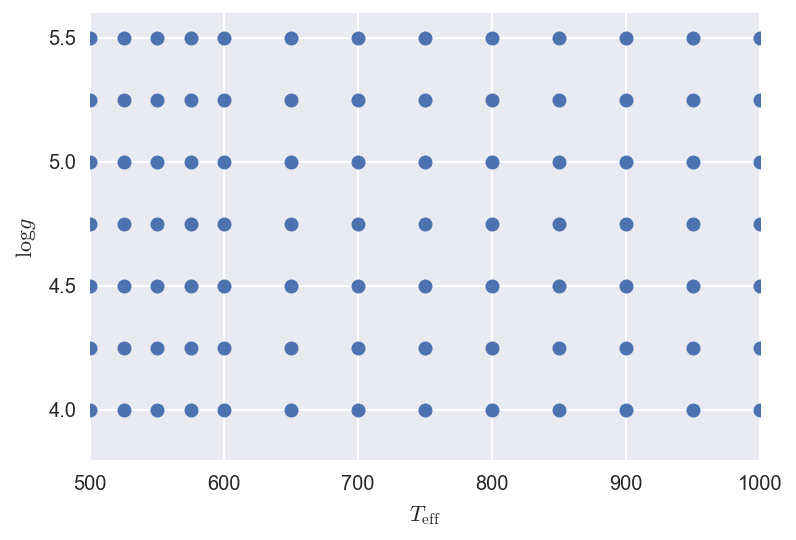

In [14]:
plt.plot(temps, np.log10(surfs), 'o')
plt.ylabel('$\log{g}$')
plt.xlabel('$T_{\mathrm{eff}}$');

The sampling is $\Delta T = 25$ K below 600 K, and $\Delta T = 50$ K above 600 K.

In [15]:
! head -n4 ../../Starfish/libraries/raw/marley/sp_t500g1000nc_m0.0

  500.     1000.   0.28  0.00  1.0000E+05   0.00   1.00  0.00    Teff,
    microns  Flux (erg/cm^2/s/Hz)

   50.0000000     5.60534E-09


In [16]:
! head -n4 ../../Starfish/libraries/raw/marley/sp_t800g3160nc_m0.0

  800.     3160.   0.28  0.00  1.0000E+05   0.00   1.00  0.00    Teff,
    microns  Flux (erg/cm^2/s/Hz)

   50.0000000     1.10384E-08


It looks like Teff and **g** change, but all other properties are held fixed.

It looks like the range in $\log{g}$ is 3.0 - 5.5, so an extra data point than what Didier Saumon said in the email:
> spectra for Teff=500-1000K, log g=3.25 - 5.5, solar composition, cloudless.

In [17]:
dat = pd.read_csv('../../Starfish/libraries/raw/marley/sp_t1000g1000nc_m0.0', 
                  names=['wavelength', 'flux'],
                  skiprows=3, 
                  delim_whitespace=True)

In [18]:
dat.head()

,wavelength,flux
0,50.000000,1.476370e-08
1,49.991676,1.546910e-08
2,49.983331,1.585290e-08
3,49.975012,1.602650e-08
4,49.966672,1.598030e-08


The units are : 
- wavelength: **micron**
- flux density: **erg/cm^2/s/Hz**

There's no solid angle, so I suppose this must be at the (sub)stellar surface?  
Let's make a new column for Starfish units.

### $\frac{d f}{d\lambda} = \frac{d f}{d \nu} \cdot \frac{d \nu}{d\lambda}$

$\nu = c \lambda^{-1}$

$\frac{d \nu}{d\lambda} = (-1) c \lambda^{-2} = (-1) \nu \lambda^{-1}$

In [19]:
import astropy.constants as C
c_val = C.c.to(u.cm/u.s).value
c_val

29979245800.0

In [20]:
x = dat.wavelength.values*u.micron
x_Hz = x.to(u.Hz, equivalencies=u.spectral())
x_Ang = x.to(u.Angstrom)


y0 = dat.flux.values*u.erg/u.cm**2/u.s/u.Hz
y = y0.to(u.erg/u.cm**2/u.s/u.Angstrom, 
          equivalencies=u.spectral_density(dat.wavelength.values*u.micron))
y2 = dat.flux.values * c_val * dat.wavelength.values**-2  ##units are funky, but still works?
y3 = dat.flux.values * x_Hz.value / x_Ang.value

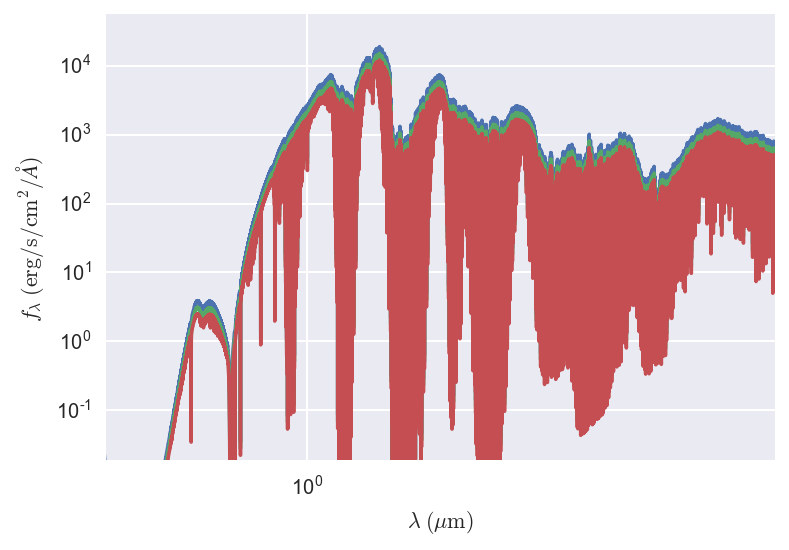

In [21]:
plt.plot(x, y)
plt.plot(x, y2*0.8)
plt.plot(x, y3*0.8**2)
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.5, 5)
plt.ylim(1.0E-6*np.nanmax(y.value), 3.0*np.nanmax(y.value))
plt.xlabel('$\lambda \;(\mu \mathrm{m})$')
plt.ylabel('$f_\lambda \;(\mathrm{erg/s/cm}^2/\AA)$ ')

They're all dead-on, right on top of each other!

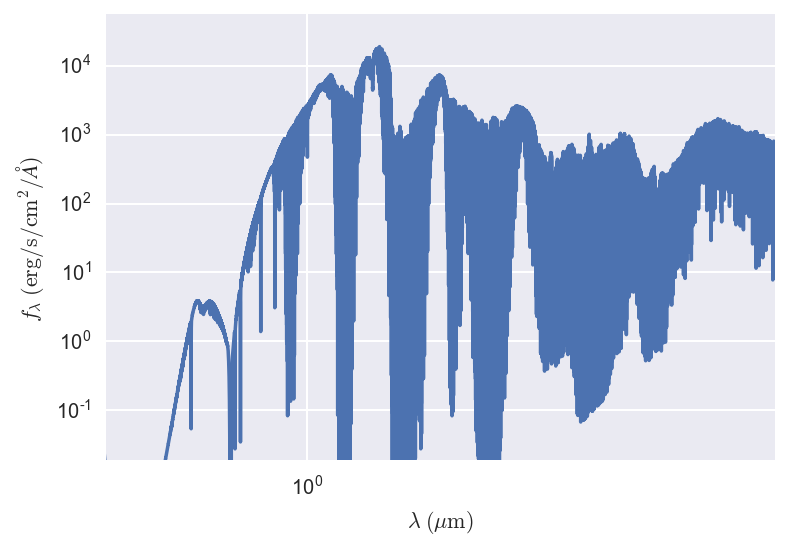

In [22]:
plt.plot(x, y)
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.5, 5)
plt.ylim(1.0E-6*np.nanmax(y.value), 3.0*np.nanmax(y.value))
plt.xlabel('$\lambda \;(\mu \mathrm{m})$')
plt.ylabel('$f_\lambda \;(\mathrm{erg/s/cm}^2/\AA)$ ')

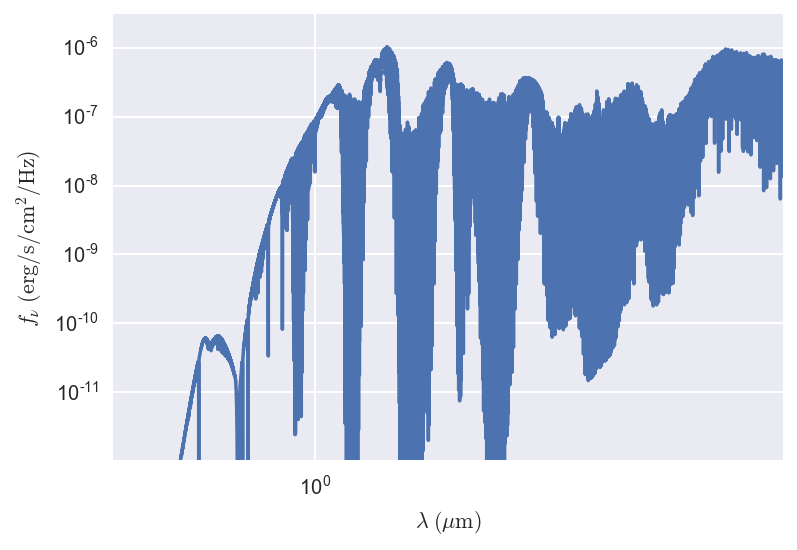

In [23]:
plt.plot(x, dat.flux)
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.5, 5)
plt.ylim(1.0E-6*np.nanmax(dat.flux.values), 3.0*np.nanmax(dat.flux.values))
plt.xlabel('$\lambda \;(\mu \mathrm{m})$')
plt.ylabel('$f_ν \;(\mathrm{erg/s/cm}^2/\mathrm{Hz})$ ')

Notice the difference between the flux densities per $\nu$ and per Angstrom.

### Compare to another model

In [23]:
dat2 = pd.read_csv('../../Starfish/libraries/raw/marley/sp_t500g1000nc_m0.0', 
                  names=['wavelength', 'flux'],
                  skiprows=3, 
                  delim_whitespace=True)

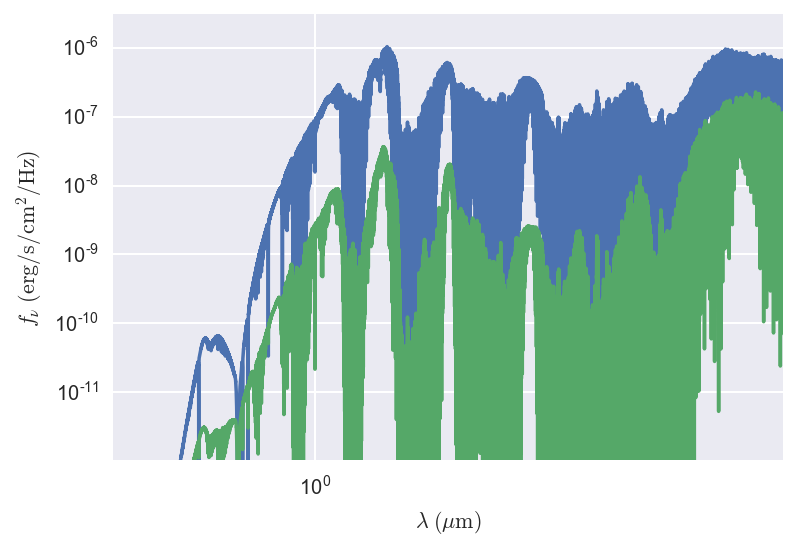

In [24]:
plt.plot(x, dat.flux)
plt.plot(dat.wavelength, dat2.flux)
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.5, 5)
plt.ylim(1.0E-6*np.nanmax(dat.flux.values), 3.0*np.nanmax(dat.flux.values))
plt.xlabel('$\lambda \;(\mu \mathrm{m})$')
plt.ylabel('$f_ν \;(\mathrm{erg/s/cm}^2/\mathrm{Hz})$ ')

Checks out.

### The end.